In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install tokenizers

In [3]:
!mkdir 'data'

In [11]:
!tar -xzvf '/content/drive/MyDrive/for_atom/aclImdb_v1.tar.gz' -C '/content/data'

Выходные данные были обрезаны до нескольких последних строк (5000).
aclImdb/train/unsup/44983_0.txt
aclImdb/train/unsup/44982_0.txt
aclImdb/train/unsup/44981_0.txt
aclImdb/train/unsup/44980_0.txt
aclImdb/train/unsup/44979_0.txt
aclImdb/train/unsup/44978_0.txt
aclImdb/train/unsup/44977_0.txt
aclImdb/train/unsup/44976_0.txt
aclImdb/train/unsup/44975_0.txt
aclImdb/train/unsup/44974_0.txt
aclImdb/train/unsup/44973_0.txt
aclImdb/train/unsup/44972_0.txt
aclImdb/train/unsup/44971_0.txt
aclImdb/train/unsup/44970_0.txt
aclImdb/train/unsup/44969_0.txt
aclImdb/train/unsup/44968_0.txt
aclImdb/train/unsup/44967_0.txt
aclImdb/train/unsup/44966_0.txt
aclImdb/train/unsup/44965_0.txt
aclImdb/train/unsup/44964_0.txt
aclImdb/train/unsup/44963_0.txt
aclImdb/train/unsup/44962_0.txt
aclImdb/train/unsup/44961_0.txt
aclImdb/train/unsup/44960_0.txt
aclImdb/train/unsup/44959_0.txt
aclImdb/train/unsup/44958_0.txt
aclImdb/train/unsup/44957_0.txt
aclImdb/train/unsup/44956_0.txt
aclImdb/train/unsup/44955_0.txt
aclI

In [12]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, GRU, LSTM, Input, Dropout,  Conv1D, MaxPooling1D
from tensorflow.keras import utils
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras import utils
from tensorflow.keras.regularizers import l1, l2
from sklearn.utils import shuffle
from tokenizers import Tokenizer
from tokenizers.models import BPE
from tokenizers.pre_tokenizers import Whitespace
from tokenizers.trainers import BpeTrainer
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [13]:
import os
import pandas as pd
data = {'review': [], 'rating': []}
def load_data(directory, data):
    for filename in os.listdir(directory):
        if filename.endswith(".txt"):
            rating = filename.split('_')[1].replace('.txt', '')
            path = os.path.join(directory, filename)
            with open(path, 'r', encoding='utf-8') as file:
                review = file.read()
            data['review'].append(review)
            data['rating'].append(rating)
    return pd.DataFrame(data)


In [16]:
pd.DataFrame(data)

,review,rating
0,This was surprisingly intelligent for a TV mov...,8
1,"ELVIRA, MISTRESS OF THE DARK (1988)<br /><br /...",9
2,Exquisite comedy starring Marian Davies (with ...,8
3,Perhaps not the absolute greatest entry in the...,7
4,We viewed the vcr and found it to be fascinati...,7
...,...,...
49995,I'm sorry to see that it has been rated that l...,10
49996,Alfred Hitchcock shows originality in the rema...,8
49997,From all of the Vietnam war movies this is pro...,10
49998,How many reviews of this film will I have to w...,10


In [15]:
df = load_data('/content/data/aclImdb/train/pos', data)
df = load_data('/content/data/aclImdb/train/neg', data)
df = shuffle(df)
df = load_data('/content/data/aclImdb/test/neg', data)
df = load_data('/content/data/aclImdb/test/pos', data)
df = shuffle(df)


In [10]:
df = pd.DataFrame(data)

In [17]:
df.shape

(50000, 2)

In [18]:
df['rating'] = df['rating'].astype(int)
df['rating'].unique()

array([10,  2,  9,  3,  7,  1,  8,  4])

In [19]:
mapping = {1:0, 2:1, 3:2, 4:3, 7:4, 8:5, 9:6, 10:7}
df['rating'] = df['rating'].map(mapping)

In [20]:
!pip install pymorphy2

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.5/55.5 kB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.2/8.2 MB 85.2 MB/s eta 0:00:00
  Created wheel for docopt: filename=docopt-0.6.2-py2.py3-none-any.whl size=13704 sha256=ec8275073d8b2b84c3ba66956da19096e6b2b6d20c40bcf04be141cce823d68f
  Stored in directory: /root/.cache/pip/wheels/fc/ab/d4/5da2067ac95b36618c629a5f93f809425700506f72c9732fac
Successfully built docopt


In [21]:
import nltk
from nltk.corpus import stopwords
import re
import pymorphy2 as p2

nltk.download('stopwords')
nltk.download('punkt')

stop_words = set(stopwords.words('english'))
def remove_stopwords(text):
  words = nltk.word_tokenize(text)
  filtered_words = [word for word in words if word.lower() not in stop_words and word.isalnum()]
  return " ".join(filtered_words)
df['filtered'] = df['review'].apply(remove_stopwords)

def remove_html(text):
  clean = re.compile('<.*?>|&.*?;')
  return re.sub(clean, '', text)

df['filtered'] = df['filtered'].apply(remove_html)

morth = p2.MorphAnalyzer()

def lematisation(array):
    array = array.split(' ')
    return [morth.parse(item)[0].normal_form for item in array]

df['filtered'] = df['filtered'].apply(lematisation)


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [22]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(df['filtered'], df['rating'], test_size=0.2, random_state=42)


In [23]:
max_len = 250  # Это может варьироваться в зависимости от данных

# Инициализируем токенизатор и тренер
tokenizer = Tokenizer(BPE())
tokenizer.pre_tokenizer = Whitespace()
trainer = BpeTrainer(special_tokens=["[UNK]", "[CLS]", "[SEP]", "[PAD]", "[MASK]"])
tokenizer.train_from_iterator(X_train.tolist(), trainer)

In [24]:
max_words = 30000
max_review_len = 350

In [25]:
X_train = X_train.apply(lambda x: ' '.join(x))
X_test = X_test.apply(lambda x: ' '.join(x))

In [26]:
sequences_train = [tokenizer.encode(text).ids for text in X_train]

sequences_test = [tokenizer.encode(text).ids for text in X_test]

In [27]:
max_index = max(max(seq) for seq in sequences_train if len(seq) > 0)
print(f'Max index: {max_index}')

Max index: 29999


In [28]:
X_train = pad_sequences(sequences_train, maxlen=max_review_len)
X_test = pad_sequences(sequences_test, maxlen=max_review_len)
y_test = utils.to_categorical(y_test, 8)
y_train = utils.to_categorical(y_train, 8)

In [159]:
# model = Sequential([
#     Input(shape=(max_review_len,)),
#     Embedding(input_dim=max_words, output_dim=100),
#     Conv1D(64, 5, activation='relu'),
#     MaxPooling1D(pool_size=4),
#     LSTM(64, return_sequences=True, kernel_regularizer=l2(0.001)),
#     LSTM(64, kernel_regularizer=l2(0.001)),
#     Dense(8, activation='softmax')
# ])
model = Sequential([
    Input(shape=(max_review_len,)),
    Embedding(input_dim=max_words, output_dim=200),
    Conv1D(64, 5, activation='relu'),
    MaxPooling1D(pool_size=4),
    # LSTM(64, return_sequences=True),
    LSTM(64),
    Dense(8, activation='softmax')
])

model.compile(optimizer='Adam', loss='categorical_focal_crossentropy', metrics=['accuracy'])


In [160]:
history = model.fit(X_train,
                    y_train,
                    batch_size=1024,
                    epochs=3,
                    validation_split=0.1)

Epoch 1/3
36/36 ━━━━━━━━━━━━━━━━━━━━ 5s 108ms/step - accuracy: 0.2200 - loss: 0.3820 - val_accuracy: 0.3582 - val_loss: 0.2998
Epoch 2/3
36/36 ━━━━━━━━━━━━━━━━━━━━ 5s 104ms/step - accuracy: 0.3816 - loss: 0.2689 - val_accuracy: 0.4080 - val_loss: 0.2439
Epoch 3/3
36/36 ━━━━━━━━━━━━━━━━━━━━ 5s 101ms/step - accuracy: 0.4742 - loss: 0.2011 - val_accuracy: 0.4275 - val_loss: 0.2431


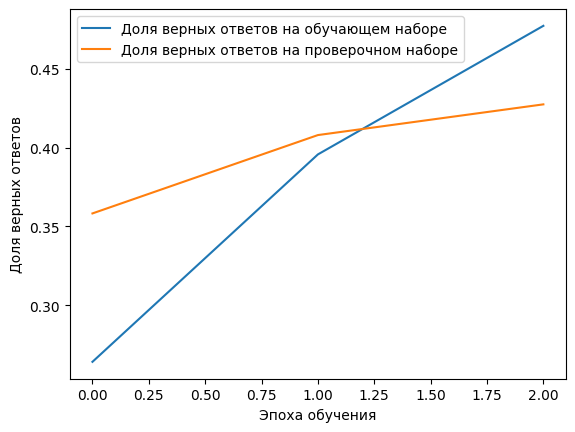

In [161]:
plt.plot(history.history['accuracy'],
         label='Доля верных ответов на обучающем наборе')
plt.plot(history.history['val_accuracy'],
         label='Доля верных ответов на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Доля верных ответов')
plt.legend()
plt.show()

In [163]:
score = model.evaluate(X_test, y_test, verbose=1)

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.4255 - loss: 0.2421


In [164]:
print(f'Точность модели = {score[1] * 100:.2f}%')

Точность модели = 42.76%


In [165]:
model.save('Fourth_model.keras')